# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

Files already downloaded and verified


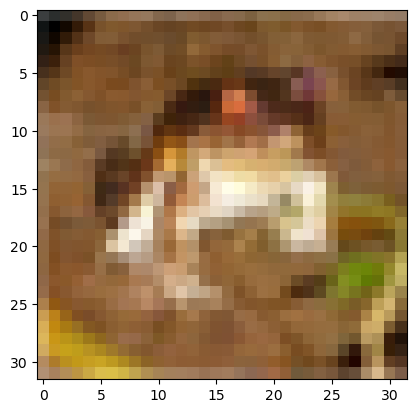

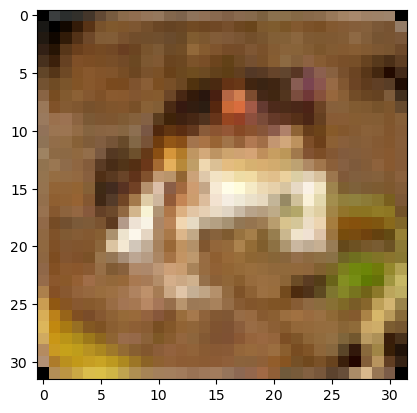

In [1]:
import torch
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import torchvision

transform = transforms.Compose([
    transforms.RandomRotation(30),                        
    transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [2]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )       

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [3]:
class ThreeLayerCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", 
                          torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
    self.model.add_module("conv3", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(8*8*channels, 10))
  
  def forward(self, x):
    return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

In [4]:
from tqdm import tqdm

augmentations = [
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(),
]

best_accuracy = 0.0
best_augmentation = None

epochs = 50

for augmentation in augmentations:
    train_transform = transforms.Compose([
        augmentation,
        transforms.ToTensor(),
    ])
    
    net = ThreeLayerCNN(channels=3, labels = 10)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for inputs, labels in train_dl:
            inputs = augmentation(inputs)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    print("Finished training with augmentation:", augmentation)

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_dl:
            inputs = augmentation(inputs) 
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print("Accuracy with augmentation:", accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_augmentation = augmentation

print("Best augmentation:", best_augmentation)
print("Best accuracy:", best_accuracy)


100%|██████████| 50/50 [10:55<00:00, 13.11s/it]


Finished training with augmentation: RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
Accuracy with augmentation: 0.49698


100%|██████████| 50/50 [08:32<00:00, 10.25s/it]


Finished training with augmentation: ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=None)
Accuracy with augmentation: 0.52338


100%|██████████| 50/50 [07:59<00:00,  9.60s/it]


Finished training with augmentation: RandomHorizontalFlip(p=0.5)
Accuracy with augmentation: 0.51838
Best augmentation: ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=None)
Best accuracy: 0.52338


# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [5]:
def mixup_data(x, y, alpha=1.0):
    lam = torch.distributions.beta.Beta(alpha, alpha).sample().item()
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def new_fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: bool = True
):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in tqdm(train_dl):
            X_batch, y_a, y_b, lam = mixup_data(X_batch, y_batch)
            X_batch, y_a, y_b = X_batch.cuda(), y_a.cuda(), y_b.cuda()
            optimiser.zero_grad()
            outputs = model(X_batch)
            loss = mixup_criterion(loss_fn, outputs, y_a, y_b, lam)
            loss.backward()
            optimiser.step()
            
        if print_metrics: 
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                ) 
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )
    print(f"Accuracy on test dl is: {val_acc}")

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji. 



In [6]:
model = ThreeLayerCNN(channels=3, labels=10)
model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
fit(model=model, optimiser=optimizer, loss_fn=loss_fn, train_dl=train_dl, val_dl= test_dl, epochs=epochs)

100%|██████████| 1563/1563 [00:06<00:00, 227.22it/s]


Epoch 0: train loss = 0.058 (acc: 0.344), validation loss = 0.058 (acc: 0.346)


100%|██████████| 1563/1563 [00:07<00:00, 207.49it/s]


Epoch 1: train loss = 0.053 (acc: 0.397), validation loss = 0.053 (acc: 0.402)


100%|██████████| 1563/1563 [00:07<00:00, 201.61it/s]


Epoch 2: train loss = 0.049 (acc: 0.441), validation loss = 0.049 (acc: 0.442)


100%|██████████| 1563/1563 [00:07<00:00, 201.62it/s]


Epoch 3: train loss = 0.047 (acc: 0.470), validation loss = 0.047 (acc: 0.470)


100%|██████████| 1563/1563 [00:07<00:00, 201.20it/s]


Epoch 4: train loss = 0.046 (acc: 0.480), validation loss = 0.046 (acc: 0.481)


100%|██████████| 1563/1563 [00:07<00:00, 201.04it/s]


Epoch 5: train loss = 0.046 (acc: 0.481), validation loss = 0.046 (acc: 0.484)


100%|██████████| 1563/1563 [00:07<00:00, 200.48it/s]


Epoch 6: train loss = 0.045 (acc: 0.490), validation loss = 0.045 (acc: 0.489)


100%|██████████| 1563/1563 [00:07<00:00, 199.52it/s]


Epoch 7: train loss = 0.045 (acc: 0.495), validation loss = 0.045 (acc: 0.498)


100%|██████████| 1563/1563 [00:07<00:00, 200.74it/s]


Epoch 8: train loss = 0.044 (acc: 0.493), validation loss = 0.045 (acc: 0.491)


100%|██████████| 1563/1563 [00:07<00:00, 202.55it/s]


Epoch 9: train loss = 0.044 (acc: 0.503), validation loss = 0.044 (acc: 0.502)


100%|██████████| 1563/1563 [00:07<00:00, 200.20it/s]


Epoch 10: train loss = 0.045 (acc: 0.492), validation loss = 0.045 (acc: 0.486)


100%|██████████| 1563/1563 [00:07<00:00, 201.85it/s]


Epoch 11: train loss = 0.044 (acc: 0.507), validation loss = 0.044 (acc: 0.504)


100%|██████████| 1563/1563 [00:07<00:00, 200.00it/s]


Epoch 12: train loss = 0.044 (acc: 0.506), validation loss = 0.044 (acc: 0.503)


100%|██████████| 1563/1563 [00:07<00:00, 201.08it/s]


Epoch 13: train loss = 0.044 (acc: 0.503), validation loss = 0.044 (acc: 0.494)


100%|██████████| 1563/1563 [00:07<00:00, 201.10it/s]


Epoch 14: train loss = 0.043 (acc: 0.512), validation loss = 0.044 (acc: 0.506)


100%|██████████| 1563/1563 [00:07<00:00, 201.00it/s]


Epoch 15: train loss = 0.044 (acc: 0.502), validation loss = 0.044 (acc: 0.496)


100%|██████████| 1563/1563 [00:07<00:00, 201.21it/s]


Epoch 16: train loss = 0.044 (acc: 0.504), validation loss = 0.045 (acc: 0.496)


100%|██████████| 1563/1563 [00:07<00:00, 199.86it/s]


Epoch 17: train loss = 0.044 (acc: 0.499), validation loss = 0.045 (acc: 0.491)


100%|██████████| 1563/1563 [00:06<00:00, 226.30it/s]


Epoch 18: train loss = 0.043 (acc: 0.513), validation loss = 0.044 (acc: 0.507)


100%|██████████| 1563/1563 [00:06<00:00, 231.35it/s]


Epoch 19: train loss = 0.043 (acc: 0.516), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:07<00:00, 199.91it/s]


Epoch 20: train loss = 0.045 (acc: 0.493), validation loss = 0.045 (acc: 0.492)


100%|██████████| 1563/1563 [00:07<00:00, 207.77it/s]


Epoch 21: train loss = 0.043 (acc: 0.510), validation loss = 0.044 (acc: 0.503)


100%|██████████| 1563/1563 [00:07<00:00, 204.04it/s]


Epoch 22: train loss = 0.043 (acc: 0.516), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:07<00:00, 203.92it/s]


Epoch 23: train loss = 0.043 (acc: 0.514), validation loss = 0.044 (acc: 0.507)


100%|██████████| 1563/1563 [00:07<00:00, 205.53it/s]


Epoch 24: train loss = 0.043 (acc: 0.513), validation loss = 0.044 (acc: 0.505)


100%|██████████| 1563/1563 [00:07<00:00, 201.95it/s]


Epoch 25: train loss = 0.043 (acc: 0.518), validation loss = 0.043 (acc: 0.510)


100%|██████████| 1563/1563 [00:07<00:00, 202.44it/s]


Epoch 26: train loss = 0.042 (acc: 0.520), validation loss = 0.043 (acc: 0.510)


100%|██████████| 1563/1563 [00:07<00:00, 200.92it/s]


Epoch 27: train loss = 0.043 (acc: 0.513), validation loss = 0.044 (acc: 0.507)


100%|██████████| 1563/1563 [00:07<00:00, 202.82it/s]


Epoch 28: train loss = 0.043 (acc: 0.516), validation loss = 0.044 (acc: 0.504)


100%|██████████| 1563/1563 [00:07<00:00, 202.00it/s]


Epoch 29: train loss = 0.044 (acc: 0.514), validation loss = 0.044 (acc: 0.503)


100%|██████████| 1563/1563 [00:07<00:00, 201.42it/s]


Epoch 30: train loss = 0.043 (acc: 0.521), validation loss = 0.043 (acc: 0.512)


100%|██████████| 1563/1563 [00:07<00:00, 201.18it/s]


Epoch 31: train loss = 0.043 (acc: 0.515), validation loss = 0.043 (acc: 0.503)


100%|██████████| 1563/1563 [00:07<00:00, 202.77it/s]


Epoch 32: train loss = 0.042 (acc: 0.522), validation loss = 0.043 (acc: 0.514)


100%|██████████| 1563/1563 [00:07<00:00, 202.41it/s]


Epoch 33: train loss = 0.042 (acc: 0.523), validation loss = 0.043 (acc: 0.516)


100%|██████████| 1563/1563 [00:07<00:00, 200.50it/s]


Epoch 34: train loss = 0.042 (acc: 0.525), validation loss = 0.043 (acc: 0.518)


100%|██████████| 1563/1563 [00:07<00:00, 200.37it/s]


Epoch 35: train loss = 0.042 (acc: 0.523), validation loss = 0.043 (acc: 0.513)


100%|██████████| 1563/1563 [00:07<00:00, 201.94it/s]


Epoch 36: train loss = 0.042 (acc: 0.524), validation loss = 0.043 (acc: 0.516)


100%|██████████| 1563/1563 [00:07<00:00, 204.34it/s]


Epoch 37: train loss = 0.042 (acc: 0.520), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:07<00:00, 199.65it/s]


Epoch 38: train loss = 0.042 (acc: 0.524), validation loss = 0.043 (acc: 0.519)


100%|██████████| 1563/1563 [00:07<00:00, 204.92it/s]


Epoch 39: train loss = 0.042 (acc: 0.523), validation loss = 0.043 (acc: 0.513)


100%|██████████| 1563/1563 [00:07<00:00, 200.99it/s]


Epoch 40: train loss = 0.042 (acc: 0.519), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:07<00:00, 202.74it/s]


Epoch 41: train loss = 0.042 (acc: 0.523), validation loss = 0.043 (acc: 0.511)


100%|██████████| 1563/1563 [00:07<00:00, 202.19it/s]


Epoch 42: train loss = 0.042 (acc: 0.528), validation loss = 0.043 (acc: 0.518)


100%|██████████| 1563/1563 [00:07<00:00, 202.46it/s]


Epoch 43: train loss = 0.042 (acc: 0.523), validation loss = 0.043 (acc: 0.513)


100%|██████████| 1563/1563 [00:07<00:00, 202.77it/s]


Epoch 44: train loss = 0.043 (acc: 0.517), validation loss = 0.044 (acc: 0.507)


100%|██████████| 1563/1563 [00:07<00:00, 203.18it/s]


Epoch 45: train loss = 0.042 (acc: 0.526), validation loss = 0.043 (acc: 0.513)


100%|██████████| 1563/1563 [00:07<00:00, 202.18it/s]


Epoch 46: train loss = 0.042 (acc: 0.527), validation loss = 0.043 (acc: 0.517)


100%|██████████| 1563/1563 [00:07<00:00, 203.42it/s]


Epoch 47: train loss = 0.042 (acc: 0.528), validation loss = 0.043 (acc: 0.518)


100%|██████████| 1563/1563 [00:07<00:00, 207.99it/s]


Epoch 48: train loss = 0.042 (acc: 0.519), validation loss = 0.044 (acc: 0.506)


100%|██████████| 1563/1563 [00:07<00:00, 208.40it/s]


Epoch 49: train loss = 0.043 (acc: 0.523), validation loss = 0.044 (acc: 0.511)


In [7]:
model = ThreeLayerCNN(channels=3, labels=10)
model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
new_fit(model=model, optimiser=optimizer, loss_fn=loss_fn, train_dl=train_dl, val_dl= test_dl, epochs=epochs)

100%|██████████| 1563/1563 [00:08<00:00, 192.15it/s]


Epoch 0: train loss = 0.054 (acc: 0.394), validation loss = 0.054 (acc: 0.394)


100%|██████████| 1563/1563 [00:09<00:00, 171.66it/s]


Epoch 1: train loss = 0.051 (acc: 0.430), validation loss = 0.051 (acc: 0.431)


100%|██████████| 1563/1563 [00:09<00:00, 170.27it/s]


Epoch 2: train loss = 0.052 (acc: 0.418), validation loss = 0.052 (acc: 0.414)


100%|██████████| 1563/1563 [00:09<00:00, 171.49it/s]


Epoch 3: train loss = 0.050 (acc: 0.448), validation loss = 0.050 (acc: 0.442)


100%|██████████| 1563/1563 [00:08<00:00, 173.67it/s]


Epoch 4: train loss = 0.048 (acc: 0.461), validation loss = 0.048 (acc: 0.455)


100%|██████████| 1563/1563 [00:08<00:00, 182.10it/s]


Epoch 5: train loss = 0.049 (acc: 0.457), validation loss = 0.049 (acc: 0.451)


100%|██████████| 1563/1563 [00:08<00:00, 189.34it/s]


Epoch 6: train loss = 0.047 (acc: 0.475), validation loss = 0.048 (acc: 0.466)


100%|██████████| 1563/1563 [00:08<00:00, 190.12it/s]


Epoch 7: train loss = 0.048 (acc: 0.469), validation loss = 0.048 (acc: 0.465)


100%|██████████| 1563/1563 [00:09<00:00, 170.43it/s]


Epoch 8: train loss = 0.047 (acc: 0.478), validation loss = 0.047 (acc: 0.475)


100%|██████████| 1563/1563 [00:09<00:00, 168.91it/s]


Epoch 9: train loss = 0.047 (acc: 0.479), validation loss = 0.047 (acc: 0.476)


100%|██████████| 1563/1563 [00:09<00:00, 167.53it/s]


Epoch 10: train loss = 0.047 (acc: 0.479), validation loss = 0.047 (acc: 0.472)


100%|██████████| 1563/1563 [00:09<00:00, 172.05it/s]


Epoch 11: train loss = 0.047 (acc: 0.480), validation loss = 0.047 (acc: 0.476)


100%|██████████| 1563/1563 [00:08<00:00, 174.81it/s]


Epoch 12: train loss = 0.047 (acc: 0.484), validation loss = 0.047 (acc: 0.479)


100%|██████████| 1563/1563 [00:09<00:00, 173.51it/s]


Epoch 13: train loss = 0.047 (acc: 0.485), validation loss = 0.047 (acc: 0.479)


100%|██████████| 1563/1563 [00:07<00:00, 200.75it/s]


Epoch 14: train loss = 0.046 (acc: 0.492), validation loss = 0.046 (acc: 0.485)


100%|██████████| 1563/1563 [00:09<00:00, 170.26it/s]


Epoch 15: train loss = 0.046 (acc: 0.494), validation loss = 0.046 (acc: 0.486)


100%|██████████| 1563/1563 [00:08<00:00, 181.99it/s]


Epoch 16: train loss = 0.047 (acc: 0.478), validation loss = 0.047 (acc: 0.472)


100%|██████████| 1563/1563 [00:08<00:00, 179.24it/s]


Epoch 17: train loss = 0.046 (acc: 0.495), validation loss = 0.046 (acc: 0.490)


100%|██████████| 1563/1563 [00:08<00:00, 173.73it/s]


Epoch 18: train loss = 0.046 (acc: 0.497), validation loss = 0.046 (acc: 0.493)


100%|██████████| 1563/1563 [00:09<00:00, 167.60it/s]


Epoch 19: train loss = 0.047 (acc: 0.482), validation loss = 0.048 (acc: 0.474)


100%|██████████| 1563/1563 [00:09<00:00, 172.88it/s]


Epoch 20: train loss = 0.046 (acc: 0.490), validation loss = 0.047 (acc: 0.480)


100%|██████████| 1563/1563 [00:09<00:00, 171.73it/s]


Epoch 21: train loss = 0.046 (acc: 0.494), validation loss = 0.046 (acc: 0.490)


100%|██████████| 1563/1563 [00:09<00:00, 170.70it/s]


Epoch 22: train loss = 0.046 (acc: 0.491), validation loss = 0.047 (acc: 0.485)


100%|██████████| 1563/1563 [00:08<00:00, 176.30it/s]


Epoch 23: train loss = 0.046 (acc: 0.490), validation loss = 0.047 (acc: 0.487)


100%|██████████| 1563/1563 [00:08<00:00, 183.84it/s]


Epoch 24: train loss = 0.046 (acc: 0.494), validation loss = 0.047 (acc: 0.486)


100%|██████████| 1563/1563 [00:09<00:00, 166.44it/s]


Epoch 25: train loss = 0.046 (acc: 0.493), validation loss = 0.046 (acc: 0.486)


100%|██████████| 1563/1563 [00:09<00:00, 164.78it/s]


Epoch 26: train loss = 0.046 (acc: 0.490), validation loss = 0.047 (acc: 0.483)


100%|██████████| 1563/1563 [00:09<00:00, 168.95it/s]


Epoch 27: train loss = 0.045 (acc: 0.499), validation loss = 0.046 (acc: 0.493)


100%|██████████| 1563/1563 [00:09<00:00, 170.11it/s]


Epoch 28: train loss = 0.045 (acc: 0.503), validation loss = 0.046 (acc: 0.496)


100%|██████████| 1563/1563 [00:08<00:00, 175.99it/s]


Epoch 29: train loss = 0.046 (acc: 0.494), validation loss = 0.046 (acc: 0.490)


100%|██████████| 1563/1563 [00:08<00:00, 190.40it/s]


Epoch 30: train loss = 0.045 (acc: 0.498), validation loss = 0.046 (acc: 0.488)


100%|██████████| 1563/1563 [00:08<00:00, 180.69it/s]


Epoch 31: train loss = 0.045 (acc: 0.503), validation loss = 0.046 (acc: 0.495)


100%|██████████| 1563/1563 [00:08<00:00, 173.92it/s]


Epoch 32: train loss = 0.045 (acc: 0.506), validation loss = 0.046 (acc: 0.497)


100%|██████████| 1563/1563 [00:09<00:00, 170.92it/s]


Epoch 33: train loss = 0.046 (acc: 0.495), validation loss = 0.046 (acc: 0.485)


100%|██████████| 1563/1563 [00:09<00:00, 163.40it/s]


Epoch 34: train loss = 0.045 (acc: 0.498), validation loss = 0.046 (acc: 0.493)


100%|██████████| 1563/1563 [00:09<00:00, 163.06it/s]


Epoch 35: train loss = 0.045 (acc: 0.497), validation loss = 0.046 (acc: 0.485)


100%|██████████| 1563/1563 [00:09<00:00, 163.01it/s]


Epoch 36: train loss = 0.045 (acc: 0.501), validation loss = 0.046 (acc: 0.495)


100%|██████████| 1563/1563 [00:09<00:00, 162.63it/s]


Epoch 37: train loss = 0.045 (acc: 0.502), validation loss = 0.046 (acc: 0.496)


100%|██████████| 1563/1563 [00:09<00:00, 165.15it/s]


Epoch 38: train loss = 0.045 (acc: 0.503), validation loss = 0.046 (acc: 0.499)


100%|██████████| 1563/1563 [00:09<00:00, 165.18it/s]


Epoch 39: train loss = 0.045 (acc: 0.506), validation loss = 0.046 (acc: 0.497)


100%|██████████| 1563/1563 [00:09<00:00, 165.46it/s]


Epoch 40: train loss = 0.045 (acc: 0.508), validation loss = 0.045 (acc: 0.499)


100%|██████████| 1563/1563 [00:09<00:00, 167.66it/s]


Epoch 41: train loss = 0.045 (acc: 0.500), validation loss = 0.046 (acc: 0.490)


100%|██████████| 1563/1563 [00:08<00:00, 173.86it/s]


Epoch 42: train loss = 0.045 (acc: 0.503), validation loss = 0.046 (acc: 0.495)


100%|██████████| 1563/1563 [00:09<00:00, 170.68it/s]


Epoch 43: train loss = 0.045 (acc: 0.500), validation loss = 0.046 (acc: 0.491)


100%|██████████| 1563/1563 [00:08<00:00, 174.25it/s]


Epoch 44: train loss = 0.045 (acc: 0.505), validation loss = 0.045 (acc: 0.494)


100%|██████████| 1563/1563 [00:08<00:00, 177.35it/s]


Epoch 45: train loss = 0.045 (acc: 0.499), validation loss = 0.046 (acc: 0.490)


100%|██████████| 1563/1563 [00:08<00:00, 182.29it/s]


Epoch 46: train loss = 0.045 (acc: 0.502), validation loss = 0.046 (acc: 0.494)


100%|██████████| 1563/1563 [00:08<00:00, 182.69it/s]


Epoch 47: train loss = 0.045 (acc: 0.511), validation loss = 0.045 (acc: 0.504)


100%|██████████| 1563/1563 [00:08<00:00, 176.56it/s]


Epoch 48: train loss = 0.046 (acc: 0.496), validation loss = 0.047 (acc: 0.488)


100%|██████████| 1563/1563 [00:08<00:00, 175.32it/s]


Epoch 49: train loss = 0.045 (acc: 0.508), validation loss = 0.046 (acc: 0.500)
Accuracy on test dl is: 0.5002999901771545


# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [8]:
from typing import List

class SkipBlock(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
    super().__init__()
    self.main_conv = nn.Sequential()
    self.main_conv.add_module("Conv 1",nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding= 1))
    self.main_conv.add_module("Relu 1", nn.ReLU())
    self.main_conv.add_module("Downsampling", nn.Conv2d(out_channels, out_channels, stride=2, kernel_size=3, padding= 1))
    
    self.side_conv = nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)
  def forward(self,x):
    main_res = self.main_conv(x)
    side_res = self.side_conv(x)
    return main_res + side_res
    
class SkipBlockCNN(torch.nn.Module):
  def __init__(self, channels: List[int], labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("res_1", SkipBlock(3, channels[0]))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
    self.model.add_module("relu_3", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(4*4*channels[2], labels))
  
  def forward(self, x):
    return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [9]:
model = SkipBlockCNN([16,32,64], labels=10)
model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
fit(model=model, optimiser=optimizer, loss_fn=loss_fn, train_dl=train_dl, val_dl= test_dl, epochs=epochs)

100%|██████████| 1563/1563 [00:08<00:00, 182.14it/s]


Epoch 0: train loss = 0.038 (acc: 0.563), validation loss = 0.039 (acc: 0.550)


100%|██████████| 1563/1563 [00:08<00:00, 192.69it/s]


Epoch 1: train loss = 0.034 (acc: 0.620), validation loss = 0.035 (acc: 0.601)


100%|██████████| 1563/1563 [00:08<00:00, 193.75it/s]


Epoch 2: train loss = 0.028 (acc: 0.691), validation loss = 0.030 (acc: 0.661)


100%|██████████| 1563/1563 [00:08<00:00, 190.78it/s]


Epoch 3: train loss = 0.026 (acc: 0.709), validation loss = 0.029 (acc: 0.672)


100%|██████████| 1563/1563 [00:08<00:00, 190.26it/s]


Epoch 4: train loss = 0.024 (acc: 0.738), validation loss = 0.029 (acc: 0.683)


100%|██████████| 1563/1563 [00:08<00:00, 190.65it/s]


Epoch 5: train loss = 0.022 (acc: 0.754), validation loss = 0.028 (acc: 0.687)


100%|██████████| 1563/1563 [00:08<00:00, 189.76it/s]


Epoch 6: train loss = 0.019 (acc: 0.786), validation loss = 0.027 (acc: 0.706)


100%|██████████| 1563/1563 [00:07<00:00, 206.99it/s]


Epoch 7: train loss = 0.019 (acc: 0.782), validation loss = 0.028 (acc: 0.693)


100%|██████████| 1563/1563 [00:07<00:00, 208.75it/s]


Epoch 8: train loss = 0.016 (acc: 0.826), validation loss = 0.027 (acc: 0.711)


100%|██████████| 1563/1563 [00:07<00:00, 210.90it/s]


Epoch 9: train loss = 0.015 (acc: 0.835), validation loss = 0.028 (acc: 0.707)


100%|██████████| 1563/1563 [00:07<00:00, 214.93it/s]


Epoch 10: train loss = 0.014 (acc: 0.841), validation loss = 0.028 (acc: 0.706)


100%|██████████| 1563/1563 [00:07<00:00, 209.55it/s]


Epoch 11: train loss = 0.013 (acc: 0.851), validation loss = 0.031 (acc: 0.702)


100%|██████████| 1563/1563 [00:07<00:00, 213.43it/s]


Epoch 12: train loss = 0.011 (acc: 0.876), validation loss = 0.031 (acc: 0.698)


100%|██████████| 1563/1563 [00:07<00:00, 209.40it/s]


Epoch 13: train loss = 0.011 (acc: 0.878), validation loss = 0.034 (acc: 0.700)


100%|██████████| 1563/1563 [00:07<00:00, 213.67it/s]


Epoch 14: train loss = 0.010 (acc: 0.891), validation loss = 0.035 (acc: 0.699)


100%|██████████| 1563/1563 [00:07<00:00, 207.83it/s]


Epoch 15: train loss = 0.009 (acc: 0.895), validation loss = 0.037 (acc: 0.692)


100%|██████████| 1563/1563 [00:08<00:00, 186.29it/s]


Epoch 16: train loss = 0.008 (acc: 0.909), validation loss = 0.037 (acc: 0.688)


100%|██████████| 1563/1563 [00:08<00:00, 186.78it/s]


Epoch 17: train loss = 0.008 (acc: 0.903), validation loss = 0.041 (acc: 0.692)


100%|██████████| 1563/1563 [00:08<00:00, 192.02it/s]


Epoch 18: train loss = 0.007 (acc: 0.918), validation loss = 0.042 (acc: 0.689)


100%|██████████| 1563/1563 [00:08<00:00, 191.48it/s]


Epoch 19: train loss = 0.007 (acc: 0.923), validation loss = 0.044 (acc: 0.689)


100%|██████████| 1563/1563 [00:08<00:00, 189.04it/s]


Epoch 20: train loss = 0.007 (acc: 0.925), validation loss = 0.046 (acc: 0.682)


100%|██████████| 1563/1563 [00:08<00:00, 188.49it/s]


Epoch 21: train loss = 0.006 (acc: 0.933), validation loss = 0.048 (acc: 0.681)


100%|██████████| 1563/1563 [00:08<00:00, 192.08it/s]


Epoch 22: train loss = 0.006 (acc: 0.926), validation loss = 0.052 (acc: 0.677)


100%|██████████| 1563/1563 [00:08<00:00, 190.21it/s]


Epoch 23: train loss = 0.006 (acc: 0.934), validation loss = 0.051 (acc: 0.678)


100%|██████████| 1563/1563 [00:07<00:00, 209.22it/s]


Epoch 24: train loss = 0.006 (acc: 0.931), validation loss = 0.053 (acc: 0.676)


100%|██████████| 1563/1563 [00:07<00:00, 214.69it/s]


Epoch 25: train loss = 0.006 (acc: 0.936), validation loss = 0.055 (acc: 0.680)


100%|██████████| 1563/1563 [00:07<00:00, 209.43it/s]


Epoch 26: train loss = 0.004 (acc: 0.950), validation loss = 0.058 (acc: 0.674)


100%|██████████| 1563/1563 [00:07<00:00, 217.23it/s]


Epoch 27: train loss = 0.005 (acc: 0.939), validation loss = 0.060 (acc: 0.675)


100%|██████████| 1563/1563 [00:07<00:00, 210.37it/s]


Epoch 28: train loss = 0.005 (acc: 0.937), validation loss = 0.058 (acc: 0.682)


100%|██████████| 1563/1563 [00:07<00:00, 211.07it/s]


Epoch 29: train loss = 0.005 (acc: 0.943), validation loss = 0.063 (acc: 0.673)


100%|██████████| 1563/1563 [00:07<00:00, 209.54it/s]


Epoch 30: train loss = 0.004 (acc: 0.949), validation loss = 0.062 (acc: 0.674)


100%|██████████| 1563/1563 [00:07<00:00, 215.02it/s]


Epoch 31: train loss = 0.004 (acc: 0.958), validation loss = 0.063 (acc: 0.677)


100%|██████████| 1563/1563 [00:07<00:00, 207.77it/s]


Epoch 32: train loss = 0.006 (acc: 0.931), validation loss = 0.068 (acc: 0.671)


100%|██████████| 1563/1563 [00:08<00:00, 186.65it/s]


Epoch 33: train loss = 0.004 (acc: 0.949), validation loss = 0.068 (acc: 0.670)


100%|██████████| 1563/1563 [00:08<00:00, 187.07it/s]


Epoch 34: train loss = 0.004 (acc: 0.954), validation loss = 0.069 (acc: 0.667)


100%|██████████| 1563/1563 [00:08<00:00, 193.55it/s]


Epoch 35: train loss = 0.004 (acc: 0.949), validation loss = 0.072 (acc: 0.679)


100%|██████████| 1563/1563 [00:08<00:00, 190.18it/s]


Epoch 36: train loss = 0.004 (acc: 0.957), validation loss = 0.073 (acc: 0.678)


100%|██████████| 1563/1563 [00:08<00:00, 188.75it/s]


Epoch 37: train loss = 0.005 (acc: 0.947), validation loss = 0.075 (acc: 0.669)


100%|██████████| 1563/1563 [00:08<00:00, 187.60it/s]


Epoch 38: train loss = 0.004 (acc: 0.953), validation loss = 0.076 (acc: 0.663)


100%|██████████| 1563/1563 [00:08<00:00, 191.49it/s]


Epoch 39: train loss = 0.005 (acc: 0.948), validation loss = 0.075 (acc: 0.670)


100%|██████████| 1563/1563 [00:08<00:00, 192.41it/s]


Epoch 40: train loss = 0.004 (acc: 0.956), validation loss = 0.075 (acc: 0.672)


100%|██████████| 1563/1563 [00:07<00:00, 211.01it/s]


Epoch 41: train loss = 0.004 (acc: 0.955), validation loss = 0.079 (acc: 0.676)


100%|██████████| 1563/1563 [00:07<00:00, 213.03it/s]


Epoch 42: train loss = 0.004 (acc: 0.956), validation loss = 0.076 (acc: 0.670)


100%|██████████| 1563/1563 [00:07<00:00, 217.22it/s]


Epoch 43: train loss = 0.004 (acc: 0.960), validation loss = 0.079 (acc: 0.674)


100%|██████████| 1563/1563 [00:07<00:00, 207.02it/s]


Epoch 44: train loss = 0.004 (acc: 0.951), validation loss = 0.077 (acc: 0.671)


100%|██████████| 1563/1563 [00:07<00:00, 208.71it/s]


Epoch 45: train loss = 0.004 (acc: 0.957), validation loss = 0.081 (acc: 0.677)


100%|██████████| 1563/1563 [00:07<00:00, 212.35it/s]


Epoch 46: train loss = 0.006 (acc: 0.937), validation loss = 0.082 (acc: 0.669)


100%|██████████| 1563/1563 [00:07<00:00, 210.41it/s]


Epoch 47: train loss = 0.004 (acc: 0.957), validation loss = 0.082 (acc: 0.673)


100%|██████████| 1563/1563 [00:07<00:00, 210.85it/s]


Epoch 48: train loss = 0.003 (acc: 0.964), validation loss = 0.084 (acc: 0.670)


100%|██████████| 1563/1563 [00:07<00:00, 196.98it/s]


Epoch 49: train loss = 0.004 (acc: 0.952), validation loss = 0.084 (acc: 0.675)


In [10]:
model = SkipBlockCNN([16,32,64], labels=10)
model.cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
new_fit(model=model, optimiser=optimizer, loss_fn=loss_fn, train_dl=train_dl, val_dl= test_dl, epochs=epochs)

100%|██████████| 1563/1563 [00:09<00:00, 165.17it/s]


Epoch 0: train loss = 0.047 (acc: 0.476), validation loss = 0.047 (acc: 0.475)


100%|██████████| 1563/1563 [00:09<00:00, 166.87it/s]


Epoch 1: train loss = 0.038 (acc: 0.580), validation loss = 0.040 (acc: 0.566)


100%|██████████| 1563/1563 [00:09<00:00, 169.54it/s]


Epoch 2: train loss = 0.035 (acc: 0.615), validation loss = 0.037 (acc: 0.596)


100%|██████████| 1563/1563 [00:09<00:00, 168.59it/s]


Epoch 3: train loss = 0.033 (acc: 0.663), validation loss = 0.035 (acc: 0.624)


100%|██████████| 1563/1563 [00:09<00:00, 165.87it/s]


Epoch 4: train loss = 0.030 (acc: 0.698), validation loss = 0.033 (acc: 0.650)


100%|██████████| 1563/1563 [00:09<00:00, 167.34it/s]


Epoch 5: train loss = 0.029 (acc: 0.702), validation loss = 0.033 (acc: 0.648)


100%|██████████| 1563/1563 [00:09<00:00, 171.10it/s]


Epoch 6: train loss = 0.027 (acc: 0.728), validation loss = 0.032 (acc: 0.662)


100%|██████████| 1563/1563 [00:08<00:00, 187.94it/s]


Epoch 7: train loss = 0.026 (acc: 0.741), validation loss = 0.031 (acc: 0.672)


100%|██████████| 1563/1563 [00:08<00:00, 189.85it/s]


Epoch 8: train loss = 0.024 (acc: 0.755), validation loss = 0.030 (acc: 0.672)


100%|██████████| 1563/1563 [00:08<00:00, 190.40it/s]


Epoch 9: train loss = 0.026 (acc: 0.740), validation loss = 0.032 (acc: 0.658)


100%|██████████| 1563/1563 [00:08<00:00, 192.29it/s]


Epoch 10: train loss = 0.022 (acc: 0.777), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1563/1563 [00:08<00:00, 189.44it/s]


Epoch 11: train loss = 0.022 (acc: 0.792), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:08<00:00, 191.44it/s]


Epoch 12: train loss = 0.022 (acc: 0.803), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:08<00:00, 189.34it/s]


Epoch 13: train loss = 0.021 (acc: 0.802), validation loss = 0.029 (acc: 0.697)


100%|██████████| 1563/1563 [00:08<00:00, 190.29it/s]


Epoch 14: train loss = 0.020 (acc: 0.806), validation loss = 0.029 (acc: 0.690)


100%|██████████| 1563/1563 [00:09<00:00, 172.47it/s]


Epoch 15: train loss = 0.019 (acc: 0.823), validation loss = 0.028 (acc: 0.701)


100%|██████████| 1563/1563 [00:09<00:00, 164.64it/s]


Epoch 16: train loss = 0.020 (acc: 0.812), validation loss = 0.029 (acc: 0.685)


100%|██████████| 1563/1563 [00:09<00:00, 166.74it/s]


Epoch 17: train loss = 0.019 (acc: 0.825), validation loss = 0.028 (acc: 0.700)


100%|██████████| 1563/1563 [00:09<00:00, 168.79it/s]


Epoch 18: train loss = 0.019 (acc: 0.821), validation loss = 0.029 (acc: 0.688)


100%|██████████| 1563/1563 [00:09<00:00, 167.85it/s]


Epoch 19: train loss = 0.019 (acc: 0.835), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:09<00:00, 166.07it/s]


Epoch 20: train loss = 0.018 (acc: 0.842), validation loss = 0.029 (acc: 0.702)


100%|██████████| 1563/1563 [00:09<00:00, 168.46it/s]


Epoch 21: train loss = 0.018 (acc: 0.835), validation loss = 0.029 (acc: 0.694)


100%|██████████| 1563/1563 [00:09<00:00, 170.68it/s]


Epoch 22: train loss = 0.019 (acc: 0.841), validation loss = 0.030 (acc: 0.691)


100%|██████████| 1563/1563 [00:08<00:00, 191.29it/s]


Epoch 23: train loss = 0.017 (acc: 0.860), validation loss = 0.028 (acc: 0.698)


100%|██████████| 1563/1563 [00:08<00:00, 189.40it/s]


Epoch 24: train loss = 0.017 (acc: 0.852), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:08<00:00, 190.70it/s]


Epoch 25: train loss = 0.017 (acc: 0.850), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:08<00:00, 191.19it/s]


Epoch 26: train loss = 0.017 (acc: 0.863), validation loss = 0.029 (acc: 0.702)


100%|██████████| 1563/1563 [00:08<00:00, 190.24it/s]


Epoch 27: train loss = 0.016 (acc: 0.871), validation loss = 0.028 (acc: 0.704)


100%|██████████| 1563/1563 [00:08<00:00, 186.90it/s]


Epoch 28: train loss = 0.016 (acc: 0.871), validation loss = 0.029 (acc: 0.698)


100%|██████████| 1563/1563 [00:08<00:00, 190.57it/s]


Epoch 29: train loss = 0.016 (acc: 0.866), validation loss = 0.029 (acc: 0.692)


100%|██████████| 1563/1563 [00:08<00:00, 190.61it/s]


Epoch 30: train loss = 0.016 (acc: 0.863), validation loss = 0.029 (acc: 0.688)


100%|██████████| 1563/1563 [00:09<00:00, 166.81it/s]


Epoch 31: train loss = 0.016 (acc: 0.867), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1563/1563 [00:09<00:00, 165.00it/s]


Epoch 32: train loss = 0.015 (acc: 0.873), validation loss = 0.028 (acc: 0.702)


100%|██████████| 1563/1563 [00:09<00:00, 169.26it/s]


Epoch 33: train loss = 0.015 (acc: 0.878), validation loss = 0.028 (acc: 0.700)


100%|██████████| 1563/1563 [00:09<00:00, 170.80it/s]


Epoch 34: train loss = 0.015 (acc: 0.869), validation loss = 0.029 (acc: 0.691)


100%|██████████| 1563/1563 [00:09<00:00, 169.04it/s]


Epoch 35: train loss = 0.015 (acc: 0.881), validation loss = 0.029 (acc: 0.702)


100%|██████████| 1563/1563 [00:09<00:00, 166.96it/s]


Epoch 36: train loss = 0.014 (acc: 0.889), validation loss = 0.028 (acc: 0.706)


100%|██████████| 1563/1563 [00:09<00:00, 169.16it/s]


Epoch 37: train loss = 0.015 (acc: 0.886), validation loss = 0.029 (acc: 0.701)


100%|██████████| 1563/1563 [00:09<00:00, 169.28it/s]


Epoch 38: train loss = 0.015 (acc: 0.893), validation loss = 0.028 (acc: 0.703)


100%|██████████| 1563/1563 [00:08<00:00, 192.05it/s]


Epoch 39: train loss = 0.015 (acc: 0.884), validation loss = 0.029 (acc: 0.702)


100%|██████████| 1563/1563 [00:08<00:00, 192.20it/s]


Epoch 40: train loss = 0.014 (acc: 0.893), validation loss = 0.028 (acc: 0.705)


100%|██████████| 1563/1563 [00:08<00:00, 190.01it/s]


Epoch 41: train loss = 0.013 (acc: 0.902), validation loss = 0.028 (acc: 0.703)


100%|██████████| 1563/1563 [00:08<00:00, 191.38it/s]


Epoch 42: train loss = 0.016 (acc: 0.881), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:08<00:00, 192.49it/s]


Epoch 43: train loss = 0.014 (acc: 0.896), validation loss = 0.029 (acc: 0.697)


100%|██████████| 1563/1563 [00:08<00:00, 189.88it/s]


Epoch 44: train loss = 0.014 (acc: 0.897), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1563/1563 [00:08<00:00, 189.88it/s]


Epoch 45: train loss = 0.014 (acc: 0.902), validation loss = 0.029 (acc: 0.700)


100%|██████████| 1563/1563 [00:08<00:00, 190.06it/s]


Epoch 46: train loss = 0.015 (acc: 0.891), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1563/1563 [00:09<00:00, 166.15it/s]


Epoch 47: train loss = 0.013 (acc: 0.901), validation loss = 0.028 (acc: 0.705)


100%|██████████| 1563/1563 [00:09<00:00, 165.35it/s]


Epoch 48: train loss = 0.013 (acc: 0.898), validation loss = 0.029 (acc: 0.702)


100%|██████████| 1563/1563 [00:09<00:00, 167.25it/s]


Epoch 49: train loss = 0.014 (acc: 0.899), validation loss = 0.029 (acc: 0.704)
Accuracy on test dl is: 0.7044999599456787
